# ASO i SWIZ 
## Pomiary małych powierzchni
### Mateusz Matyjasiak 286376

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.restoration import unwrap_phase
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow as imshow
import os

In [ ]:
def normalize(x):
  return (x-np.min(x))/(np.max(x)-np.min(x))

## Próba zamodelowania structured light 3D phase shift dla 3 wzorców

### Generator sinusoidlanych wzorców



255.0 0.0


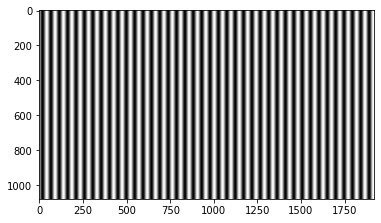

In [ ]:
width=1920
height=1080
numberOfPatterns=3
numberOfPEriods=40
period=width/numberOfPEriods
frequency=1.0/period
shiftVal=2.0*np.pi/3.0
patterns=np.zeros((height,width,numberOfPatterns))

for i in range(numberOfPatterns):
  for j in range(width):
    patterns[:,j,i]=(127.5 + 127.5*np.sin(2.0* np.pi * frequency*j+ (-shiftVal+i*shiftVal))).astype('uint8')
  plt.imshow(patterns[:,:,i],cmap="gray")
  cv2.imwrite(f"patter_{i}.png",patterns[:,:,i].astype('uint8'))

print(np.max(patterns[:,:,i]),np.min(patterns[:,:,i]))

In [ ]:
def computePhaseMap(im1,im2,im3):
  temp1=np.sqrt(3.0)*((im1-im3)/(2.0*im2-im1-im3))
  temp = np.arctan2(np.sqrt(3.0)*(im1-im3),(2.0*im2-im1-im3))
  temp= np.nan_to_num(temp,nan=0.0)
  return temp

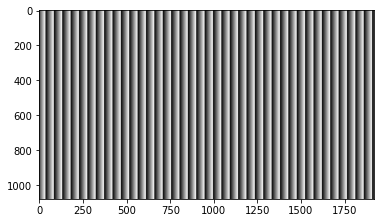

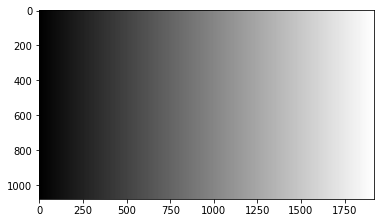

In [ ]:
test=computePhaseMap(patterns[:,:,0],patterns[:,:,1],patterns[:,:,2])
test_un=unwrap_phase(test)
cv2.imwrite("test.png",test*255)
plt.imshow(test,cmap='gray')
plt.show()
plt.imshow(test_un,cmap='gray')
plt.show()


### Wyniki

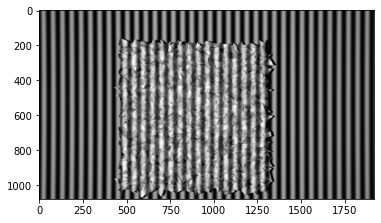

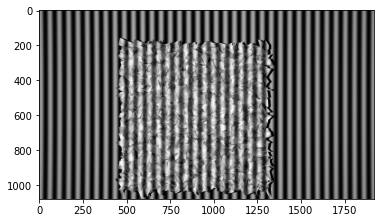

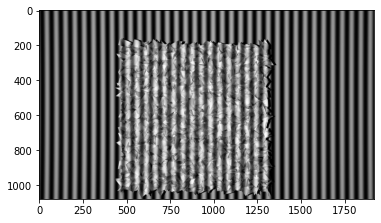

In [ ]:
img1=cv2.imread("r1.png",0).astype(float)/255.0
img2=cv2.imread("r2.png",0).astype(float)/255.0
img3=cv2.imread("r3.png",0).astype(float)/255.0



s1=cv2.imread("s1.png",0).astype(float)/255.0
s2=cv2.imread("s2.png",0).astype(float)/255.0
s3=cv2.imread("s3.png",0).astype(float)/255.0

plt.imshow(img1,cmap='gray')
plt.show()

plt.imshow(img2,cmap='gray')
plt.show()

plt.imshow(img3,cmap='gray')
plt.show()


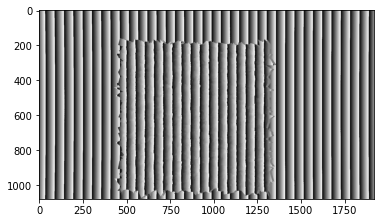

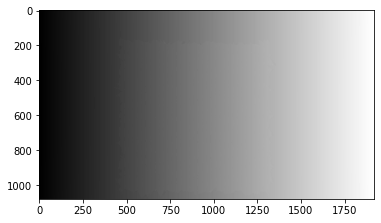

In [ ]:
p=computePhaseMap(img1,img2,img3)
un_phase=unwrap_phase(p)
plt.imshow(p,cmap='gray')
plt.show()
cv2.imwrite("phase.png",normalize(p)*255)
plt.imshow(un_phase,cmap='gray')
cv2.imwrite("unwrpa.png",normalize(un_phase)*255)
plt.show()

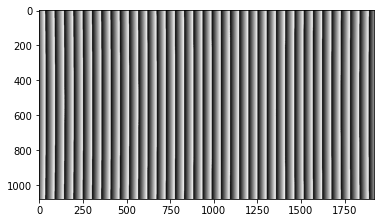

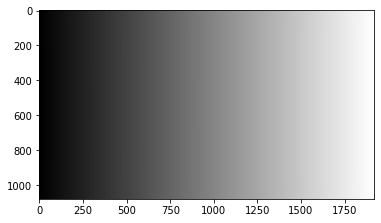

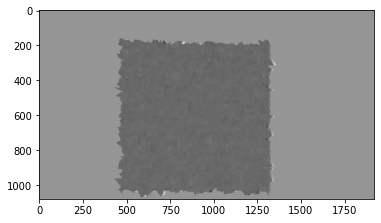

True

In [ ]:
p2=computePhaseMap(s1,s2,s3)
un2=unwrap_phase(p2)
un3=un2-un_phase

plt.imshow(p2,cmap='gray')
plt.show()
plt.imshow(un2,cmap='gray')
plt.show()

plt.imshow(un3,cmap='gray')
plt.show()

cv2.imwrite("dept.png",normalize(un3)*255)

Na obiekcie po znormalizowaniu

True

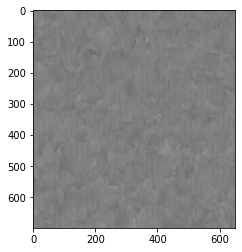

In [ ]:
slice1=un3[300:1000,550:1200]
plt.imshow(normalize(slice1)*255,cmap='gray')
cv2.imwrite("un3.png",un3)

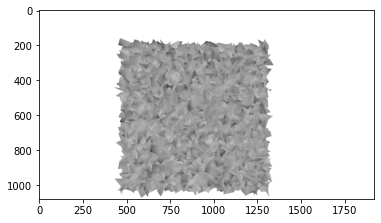

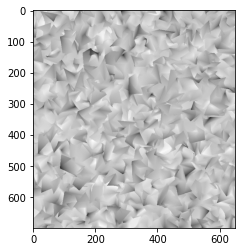

In [ ]:
gt=cv2.imread("gt.png",0).astype(float)
plt.imshow(gt,cmap='gray')
plt.show()

slice2=gt[300:1000,550:1200]

plt.imshow(normalize(slice2),cmap='gray')
plt.show()

## Klasyfikacja

In [ ]:
!pip install mahotas

     |████████████████████████████████| 5.7MB 2.9MB/s 


In [ ]:
from sklearn.svm import SVC
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
import mahotas
from sklearn.metrics import roc_curve

Korzystamy z SVM i ADA

In [ ]:
models = []
models.append(('SVM', SVC(random_state=9)))
models.append(('ADA', AdaBoostClassifier()))

Wektory cech: haralick i lbp

In [ ]:
def fd_lbp(img,tiles=(3,3)):
  lbp=mahotas.features.lbp(img,1,8)
  return lbp

def fd_haralick(img):
  haralick = mahotas.features.haralick(img).mean(axis=0)
  return haralick

In [ ]:
!unzip dataset

Archive:  dataset.zip
   creating: dataset/rough/
  inflating: dataset/rough/r0.png    
  inflating: dataset/rough/r1.png    
  inflating: dataset/rough/r10.png   
  inflating: dataset/rough/r11.png   
  inflating: dataset/rough/r12.png   
  inflating: dataset/rough/r13.png   
  inflating: dataset/rough/r14.png   
  inflating: dataset/rough/r15.png   
  inflating: dataset/rough/r16.png   
  inflating: dataset/rough/r17.png   
  inflating: dataset/rough/r18.png   
  inflating: dataset/rough/r19.png   
  inflating: dataset/rough/r2.png    
  inflating: dataset/rough/r20.png   
  inflating: dataset/rough/r3.png    
  inflating: dataset/rough/r4.png    
  inflating: dataset/rough/r5.png    
  inflating: dataset/rough/r6.png    
  inflating: dataset/rough/r7.png    
  inflating: dataset/rough/r8.png    
  inflating: dataset/rough/r9.png    
  inflating: dataset/rough/s21.png   
  inflating: dataset/rough/s22.png   
  inflating: dataset/rough/s23.png   
   creating: dataset/smooth/
  inflati

In [ ]:
def splitImage(img,tiles=(4,3)):
  width=int(img.shape[1]/tiles[0])
  height=int(img.shape[0]/tiles[1])
  images=[]
  for i in range(tiles[0]):
    for j in range(tiles[1]):
      images.append(img[j*height:(j+1)*height,i*width:(i+1)*width])
  return images

Podział obrazów, zapis scieżek do zmiennych i generacja wektora przyporządkowania. 

In [ ]:
train_path=("dataset")
tra=("dataset/train")
os.mkdir(tra)
os.mkdir(os.path.join(tra,"rough"))
os.mkdir(os.path.join(tra,"smooth"))
images_path=[]
train_labels = os.listdir(train_path)
for l in train_labels:
  dir=os.path.join(train_path,l)
  save_dir=os.path.join(tra,l)
  files=os.listdir(dir)
  iter=0;
  for f in files:
    
    img_dir=os.path.join(dir,f)
    img=cv2.imread(img_dir,0)
    if img is None:continue
    images=splitImage(img)
    for im in images:
      full_save_dir=os.path.join(save_dir,f"{iter}.png")
      images_path.append(full_save_dir)
      t=cv2.imwrite(full_save_dir,im)
      iter+=1

X=np.array(images_path) 
first_labels=np.zeros(iter)
second_labels=np.ones(iter)
y=np.append(first_labels,second_labels)

Chropowata powierzchnia


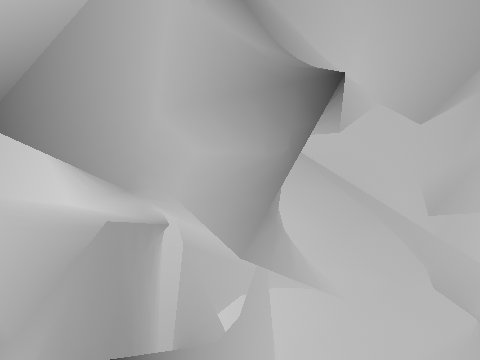

Gładka powierzchnia


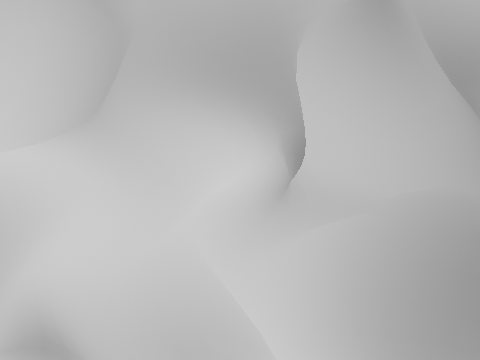

In [ ]:
imgsharp=cv2.imread(X[0])
imgsmooth=cv2.imread(X[-1])
print("Chropowata powierzchnia")
imshow(imgsharp)
print("Gładka powierzchnia")
imshow(imgsmooth)

Podział zbioru na testowy i treningowy.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
fd_haralick_global=[]
fd_lbp_global=[]

for m in X_train:
  img=cv2.imread(m,0)
  fd_haralick_global.append(fd_haralick(img))
  fd_lbp_global.append(fd_lbp(img))


Uczenie

In [ ]:
testSVMharalick = SVC().fit(fd_haralick_global, y_train)
testSVMlbp = SVC().fit(fd_lbp_global, y_train)
testADAharalick = AdaBoostClassifier().fit(fd_haralick_global, y_train)
testADAlbp = AdaBoostClassifier().fit(fd_lbp_global, y_train)

Testy

In [ ]:
resultSVMharalick=[]
resultSVMlbp=[]
resultADAharalick=[]
resultADAlbp=[]
for m in X_test:
  img=cv2.imread(m,0)
  har=fd_haralick(img).reshape(1, -1)
  lbp=fd_lbp(img).reshape(1, -1)
  resultSVMharalick.append(testSVMharalick.decision_function(har))
  resultSVMlbp.append(testSVMlbp.decision_function(lbp))
  resultADAharalick.append(testADAharalick.predict_proba(har)[:,1])
  resultADAlbp.append(testADAlbp.predict_proba(lbp)[:,1])

allresults=[resultSVMharalick,resultSVMlbp,resultADAharalick,resultADAlbp]
legend=["SVM haralick","SVM lbp", "ADA haralick", "ADA lbp"]

Krzywa ROC

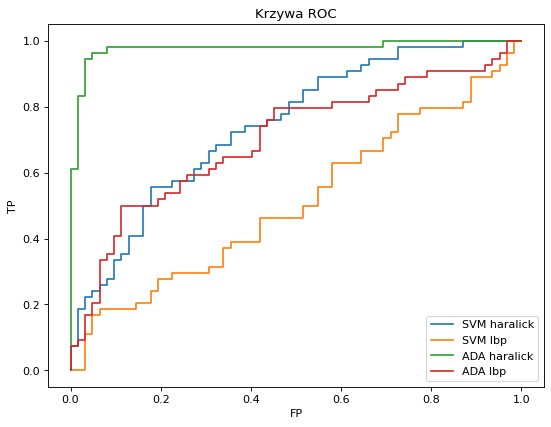

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
for i,res in enumerate(allresults):
  fpr,tpr,_=roc_curve(y_test,res)
  plt.plot(fpr,tpr,label=legend[i])
plt.legend()
plt.xlabel("FP")
plt.ylabel("TP")
plt.title("Krzywa ROC")
plt.show()